In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

#analysis_name = 'simulated_data_small'
analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])



In [3]:
class LogisticGLMMLogPosterior(object):
    def __init__(
        self, glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec):

        self.glmm_par_draw = copy.deepcopy(glmm_par_draw)
        self.prior_par = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.K = x_mat.shape[1]

        assert np.min(y_g_vec) == 0
        assert np.max(y_g_vec) == self.glmm_par_draw['u'].size() - 1

    def get_log_prior(self):
        beta = self.glmm_par_draw['beta'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)
        
        cov_beta = np.zeros((self.K, self.K))
        beta_prior_info = self.prior_par['beta_prior_info'].get()
        beta_prior_mean = self.prior_par['beta_prior_mean'].get()
        log_p_beta = ef.mvn_prior(
            beta_prior_mean, beta_prior_info, beta, cov_beta)

        log_p_mu = ef.uvn_prior(
            self.prior_par['mu_prior_mean'].get(),
            self.prior_par['mu_prior_info'].get(), mu, 0.0)

        tau_prior_shape = self.prior_par['tau_prior_alpha'].get()
        tau_prior_rate = self.prior_par['tau_prior_beta'].get()
        log_p_tau = ef.gamma_prior(
            tau_prior_shape, tau_prior_rate, tau, log_tau)

        return log_p_beta + log_p_mu + log_p_tau

    def get_log_lik(self):
        beta = self.glmm_par_draw['beta'].get()
        u = self.glmm_par_draw['u'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)

        log_lik = 0.

        # Log likelihood from data.
        z = u[self.y_g_vec] + np.matmul(self.x_mat, beta)
        log_lik += np.sum(self.y_vec * z - np.log1p(np.exp(z)))

        # Log likelihood from random effect terms.
        log_lik += -0.5 * tau * np.sum((mu - u) ** 2) + 0.5 * log_tau * len(u)

        return log_lik

    def get_log_posterior(self):
        return np.squeeze(
            self.get_log_lik() + \
            self.get_log_prior())




In [4]:
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

glmm_par_draw = vb.ModelParamsDict('GLMM Parameter Draw')
glmm_par_draw.push_param(vb.ScalarParam('mu', val=0.0))
glmm_par_draw.push_param(vb.ScalarParam('tau', val=1.0))
glmm_par_draw.push_param(vb.VectorParam('beta', K, val=np.full(K, 0.)))
glmm_par_draw.push_param(vb.VectorParam('u', NG))

log_model = LogisticGLMMLogPosterior(glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec)
log_model.get_log_posterior()

-42905.344740757813

In [5]:
class LogisticGLMMBootstrap(object):
    def __init__(self, model):
        self.model = model
        self.weights = np.full(model.x_mat.shape[0], 1.0)
        self.num_gh_points = 5
        self.model.set_gh_points(self.num_gh_points)
        
        self.get_weight_obs_jacobian = autograd.grad(
            self.get_data_log_lik_term)
        
        self.obs = 0
        
    def get_data_log_lik_term(self, free_par, obs):
        self.model.glmm_par.set_free(free_par)
        return logit_glmm.get_data_log_lik_terms(
                glmm_par = self.model.glmm_par,
                x_mat = np.atleast_2d(self.model.x_mat[obs, :]),
                y_vec = np.atleast_1d(self.model.y_vec[obs]),
                y_g_vec = np.atleast_1d(self.model.y_g_vec[obs]),
                gh_x = self.model.gh_x,
                gh_w = self.model.gh_w)[0]
    
    def get_weight_jacobian_list(self, free_par):
        weight_jacobian_list = []
        #np.full((self.model.x_mat.shape[0], len(free_par)), float('nan'))
        print('Running.')
        for obs in range(self.model.x_mat.shape[0]):
            if obs % 1000 == 0:
                print('Obs {}'.format(obs))
            weight_jacobian_list.append(self.get_weight_obs_jacobian(free_par, obs))
        print('Done.')
        return weight_jacobian_list
            
    def wrap_data_log_lik_terms(self, free_par):
        self.model.glmm_par.set_free(free_par)
        return self.model.get_data_log_lik_terms()

    def optimize_with_weights(self, weights, init_par, preconditioner, gtol=1e-6, print_every=1):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.tr_optimize_cond(
            init_par, preconditioner=preconditioner,
            num_gh_points=self.num_gh_points, gtol=gtol, print_every=print_every)   
    
    def get_model_weight_grad(self, free_par_vec, weights):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.objective.fun_free_grad(free_par_vec)

    
glmm_bootstrap_object = LogisticGLMMBootstrap(model)

glmm_par_free = vb_data['glmm_par_free']
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
moment_jac = vb_data['moment_jac']
print(elbo_hess.shape)

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)


(10014, 10014)


In [6]:
preconditioner = sp.sparse.diags([1 / np.sqrt(-1. * elbo_hess.diagonal())], [0])
cond_init = sp.sparse.linalg.spsolve(preconditioner, glmm_par_free)


/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [7]:
base_weights = np.full(NObs, 1.0)
print(np.sum(base_weights))
base_opt = glmm_bootstrap_object.optimize_with_weights(
    preconditioner=preconditioner,
    weights=base_weights, init_par=cond_init, gtol=1e-8)
base_free_par = glmm_bootstrap_object.model.objective.uncondition_x(base_opt.x)

61895.0
Iter  0  value:  23825.6902287
Iter  1  value:  23825.6899053
Iter  2  value:  23825.6898994
Iter  3  value:  23825.689899
Iter  4  value:  23825.689899
Optimization terminated successfully.
         Current function value: 23825.689899
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0


In [68]:
moment_jac_time = time.time()
moment_jac = moment_wrapper.get_moment_jacobian(base_free_par)
moment_jac_time = time.time() - moment_jac_time

moment_jac_sp = sp.sparse.csr_matrix(moment_jac)

print('Time: ', moment_jac_time)


Time:  8.669025897979736


In [8]:
# Get a sparse Jacobian.
# sparse_model = logit_glmm.SparseModelObjective(
#     model.glmm_par, model.prior_par, model.x_mat, model.y_vec, model.y_g_vec,
#     num_gh_points=model.num_gh_points, num_groups=1)

# sparse_model.glmm_par.set_free(model.glmm_par.get_free())
jac_time = time.time()
weight_jacobian = model.get_sparse_weight_free_jacobian(base_free_par, print_every_n=100)
jac_time = time.time() - jac_time

print('Jacobian time: ', jac_time)


Group 0 of 4999
Group 100 of 4999
Group 200 of 4999
Group 300 of 4999
Group 400 of 4999
Group 500 of 4999
Group 600 of 4999
Group 700 of 4999
Group 800 of 4999
Group 900 of 4999
Group 1000 of 4999
Group 1100 of 4999
Group 1200 of 4999
Group 1300 of 4999
Group 1400 of 4999
Group 1500 of 4999
Group 1600 of 4999
Group 1700 of 4999
Group 1800 of 4999
Group 1900 of 4999
Group 2000 of 4999
Group 2100 of 4999
Group 2200 of 4999
Group 2300 of 4999
Group 2400 of 4999
Group 2500 of 4999
Group 2600 of 4999
Group 2700 of 4999
Group 2800 of 4999
Group 2900 of 4999
Group 3000 of 4999
Group 3100 of 4999
Group 3200 of 4999
Group 3300 of 4999
Group 3400 of 4999
Group 3500 of 4999
Group 3600 of 4999
Group 3700 of 4999
Group 3800 of 4999
Group 3900 of 4999
Group 4000 of 4999
Group 4100 of 4999
Group 4200 of 4999
Group 4300 of 4999
Group 4400 of 4999
Group 4500 of 4999
Group 4600 of 4999
Group 4700 of 4999
Group 4800 of 4999
Group 4900 of 4999
Jacobian time:  58.233675718307495


In [9]:
hess_time = time.time()
kl_hess = model.get_sparse_free_hessian(base_free_par, print_every_n=100)
hess_time = time.time() - hess_time

Group 0 of 4999.
Group 100 of 4999.
Group 200 of 4999.
Group 300 of 4999.
Group 400 of 4999.
Group 500 of 4999.
Group 600 of 4999.
Group 700 of 4999.
Group 800 of 4999.
Group 900 of 4999.
Group 1000 of 4999.
Group 1100 of 4999.
Group 1200 of 4999.
Group 1300 of 4999.
Group 1400 of 4999.
Group 1500 of 4999.
Group 1600 of 4999.
Group 1700 of 4999.
Group 1800 of 4999.
Group 1900 of 4999.
Group 2000 of 4999.
Group 2100 of 4999.
Group 2200 of 4999.
Group 2300 of 4999.
Group 2400 of 4999.
Group 2500 of 4999.
Group 2600 of 4999.
Group 2700 of 4999.
Group 2800 of 4999.
Group 2900 of 4999.
Group 3000 of 4999.
Group 3100 of 4999.
Group 3200 of 4999.
Group 3300 of 4999.
Group 3400 of 4999.
Group 3500 of 4999.
Group 3600 of 4999.
Group 3700 of 4999.
Group 3800 of 4999.
Group 3900 of 4999.
Group 4000 of 4999.
Group 4100 of 4999.
Group 4200 of 4999.
Group 4300 of 4999.
Group 4400 of 4999.
Group 4500 of 4999.
Group 4600 of 4999.
Group 4700 of 4999.
Group 4800 of 4999.
Group 4900 of 4999.


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [14]:
# Too bad you can't pickle sparse cholesky decomposition.

from scikits.sparse.cholmod import cholesky

inverse_time = time.time()

print('Cholesky:')
elbo_hess_chol = cholesky(elbo_hess)

print('Solve:')
param_boot_mat = -1 * elbo_hess_chol.solve_A(weight_jacobian.T)

print('Done.')

inverse_time = time.time() - inverse_time


Cholesky:
Solve:


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


Done.


In [66]:
# Evaluated at a linear combination of the bootstrap draw and base weights.
# Note that at the full bootstrap draw, the response is quite nonlinear.

use_jackknife = True
if use_jackknife:
    boot_draw = copy.deepcopy(base_weights)
    boot_draw[0] = 0.
else:
    boot_draw = np.random.multinomial(NObs, [1. / NObs] * NObs, size=1) - 1.0
    boot_draw = 1.0 * boot_draw + base_weights

print('Total weight (there are {} observations): {}'.format(NObs, np.sum(boot_draw)))

lr_param_diff = param_boot_mat * (np.squeeze(boot_draw) - 1.0)

# Optionally, try taking a Newton step using the Hessian.
model_weight_grad = glmm_bootstrap_object.get_model_weight_grad(
    base_free_par + lr_param_diff, boot_draw)
model_weight_grad_sp = sp.sparse.csc_matrix(np.expand_dims(model_weight_grad, axis=1))
boot_newton_step_sp = -1 * elbo_hess_chol.solve_A(model_weight_grad_sp)
boot_newton_step = np.asarray(boot_newton_step_sp)
print(np.max(np.abs(boot_newton_step)))

Total weight (there are 61895 observations): 61894.0
0.00512583235249


In [67]:
preconditioner = sp.sparse.diags([1 / np.sqrt(kl_hess.diagonal())], [0])
cond_init = sp.sparse.linalg.spsolve(preconditioner, base_free_par + lr_param_diff)

glmm_par_opt_boot = glmm_bootstrap_object.optimize_with_weights(
    preconditioner=preconditioner,
    init_par=cond_init, weights=boot_draw, gtol=1e-8)
boot_free_par = glmm_par_opt_boot.x

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Iter  0  value:  23824.9184799
Iter  1  value:  23824.9184065
Iter  2  value:  23824.9184064
Iter  3  value:  23824.9184064
         Current function value: 23824.918406
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 3
         Hessian evaluations: 0


70.7768100517


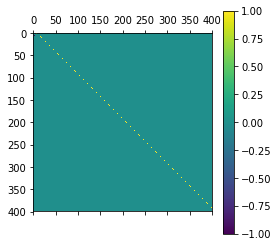

In [69]:
plt.matshow(moment_jac[0:400, 0:400]); plt.colorbar()
print(np.linalg.norm(moment_jac))

In [99]:
moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)

num_t = 10
moment_vec_pert_list = []
t_list = np.linspace(0, 1, num_t)
for t in t_list:
    moment_vec_pert_list.append(
        moment_wrapper.get_moment_vector_from_free(base_free_par + t * lr_param_diff) -
        moment_vec)

derivs = moment_jac_sp * lr_param_diff

-0.0011553293015040178

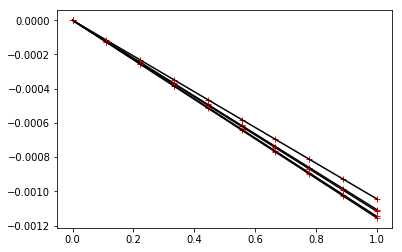

In [109]:

# offset = 2000
# for ind in range(offset, offset + 50):
#     plt.plot(t_list, [moment_vec_pert_list[i][ind] for i in range(num_t)])

plt.figure()
offset = 500
for ind in range(offset, offset + 5):
    plt.plot(t_list, [moment_vec_pert_list[i][ind] for i in range(num_t)], 'r+')
    plt.plot(t_list, t_list * derivs[ind], 'k')

derivs[ind]


264.507382652
0.0998246429159
True norm difference: 331.7342908736948


[-10, 10, -10, 10]

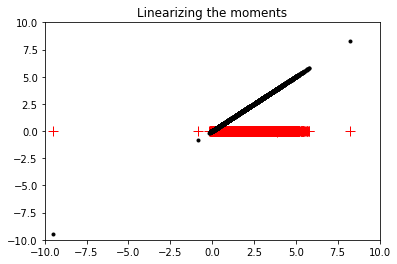

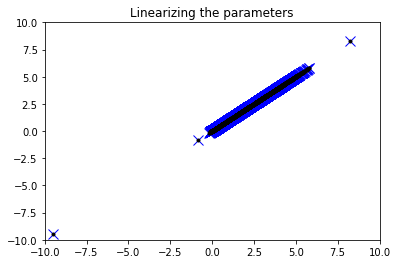

In [73]:
# The actual change in the moment vectors.
moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)

# Use the linear approximation for the parameters, not the moments.
moment_vec_boot_step = moment_wrapper.get_moment_vector_from_free(
    base_free_par + lr_param_diff)
boot_step_moment_diff = moment_vec_boot - moment_vec_boot_step
print(np.max(np.abs(boot_step_moment_diff)))

# The difference based on a linear approximation to the moments.
# lr_moment_diff = \
#     moment_jac_sp * (param_boot_mat * (np.squeeze(boot_draw) - 1.0))
lr_moment_diff = moment_jac_sp * lr_param_diff
print(np.max(np.abs(lr_moment_diff)))
    
true_moment_diff = moment_vec_boot - moment_vec
print('True norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

plt.figure()
plt.title('Linearizing the moments')
plt.plot(true_moment_diff, lr_moment_diff, 'r+', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Linearizing the parameters')
plt.plot(true_moment_diff, boot_step_moment_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
plt.axis([-10, 10, -10, 10])


Moment Parameters:
	e_beta:
[0 1 2 3 4]
	e_mu: [5]
	e_tau: [6]
	e_log_tau: [7]
	e_u:
[   8    9   10 ..., 5005 5006 5007]
[0, 1, 2, 3, 4, 5, 6, 7]


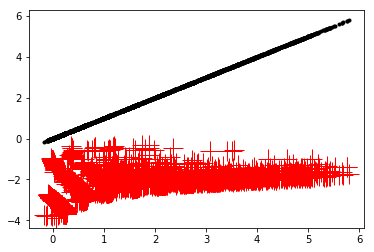

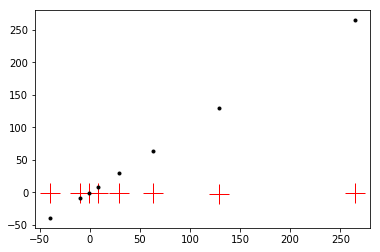

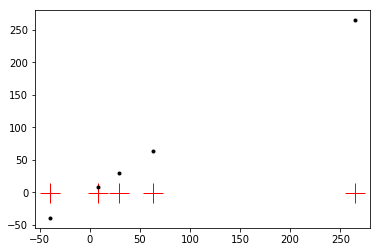

In [26]:
moment_indices = copy.deepcopy(moment_wrapper.moment_par)
moment_indices.set_vector(np.arange(0, moment_indices.vector_size()))
print(moment_indices)
u_ind = moment_indices['e_u'].get()
beta_ind = moment_indices['e_beta'].get()
non_u_ind = list(set(moment_indices.get_vector()) - set(u_ind))
print(non_u_ind)

#true_moment_diff[u_ind]

plt.figure()
plt.plot(true_moment_diff[u_ind], lr_moment_diff[u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[u_ind], true_moment_diff[u_ind], 'k.')

plt.figure()
plt.plot(true_moment_diff[non_u_ind], lr_moment_diff[non_u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[non_u_ind], true_moment_diff[non_u_ind], 'k.')


plt.figure()
plt.plot(true_moment_diff[beta_ind], lr_moment_diff[beta_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[beta_ind], true_moment_diff[beta_ind], 'k.')